In [123]:
import numpy as np
import pandas as pd
from util import loess
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Now, we can load the data at data.csv and turn it into the predictor X and the target y

In [124]:
data = pd.read_csv("./data.csv", header=None)
X = data.iloc[:, 0].to_numpy()
y = data.iloc[:, 1].to_numpy()
X.shape

(100,)

Create a scatterplot of the data. 

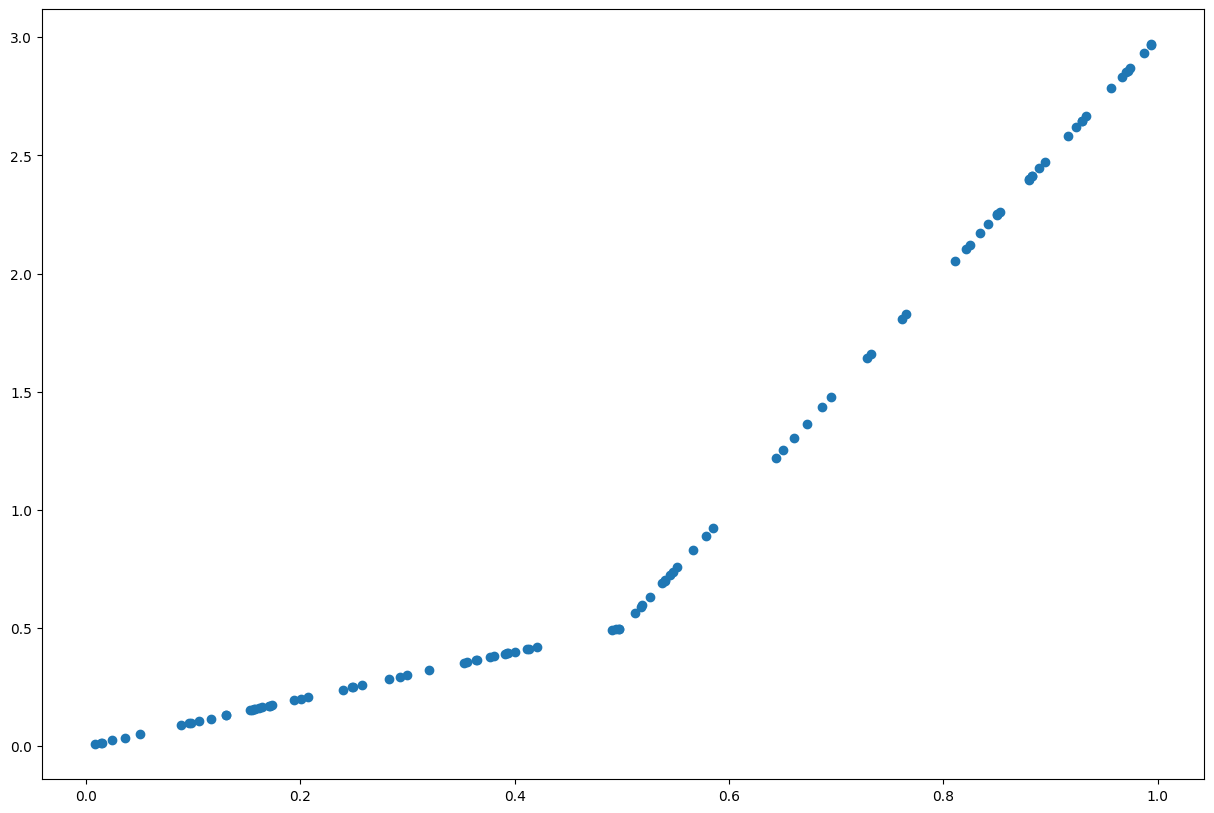

In [125]:
plt.figure()
plt.scatter(X,y)

### Comments on relationship
The relationship is non-linear overall. However, it appears to be linear in each of the ranges $[0, 0.5 - \epsilon]$ and $[0.5 + \epsilon, 1]$ for some "small" value of $\epsilon$. 

Hence, we would describe it as piece-wise linear. 

We now define the kernels $K_1,...,K_4$ as

In [126]:
import math

def K1(x, x_):
    return 1

def K2(x, x_, lam):
    k = (x - x_) / lam
    return pow((1 - pow(abs(k), 3)), 3)

def K3(x, x_, lam):
    return math.exp(-lam * pow(abs(x - x_), 2))

def K4(x, x_, L):
    for l in range(1,L):
        if x >= (l-1)/L and x_ < l/L:
            return 1
    return 0

To write the function which takes $X, y$ and a kernel $K$ as input, we can do the following

In [127]:
def pred(X, y, K):
    from sklearn.metrics.pairwise import pairwise_kernels
    # Start by computing the matrix of all weights we'll need at once.
    weights = pairwise_kernels(X.reshape(-1,1), metric=K)
    # Now, for each point we can compute the model using the corresponding weights, and make a prediction.
    y_hat = np.empty_like(y)
    for i in range(len(y)):
        model = loess(X, y, weights[i,:])
        model.fit()
        y_hat[i] = model.predict(X[i])
    # Return a vector of the predictions at each point in X.
    return y_hat

To actually use this function and show the fits of each kernel, we can iterate over all the kernels and fit the LOESS model for each of them.

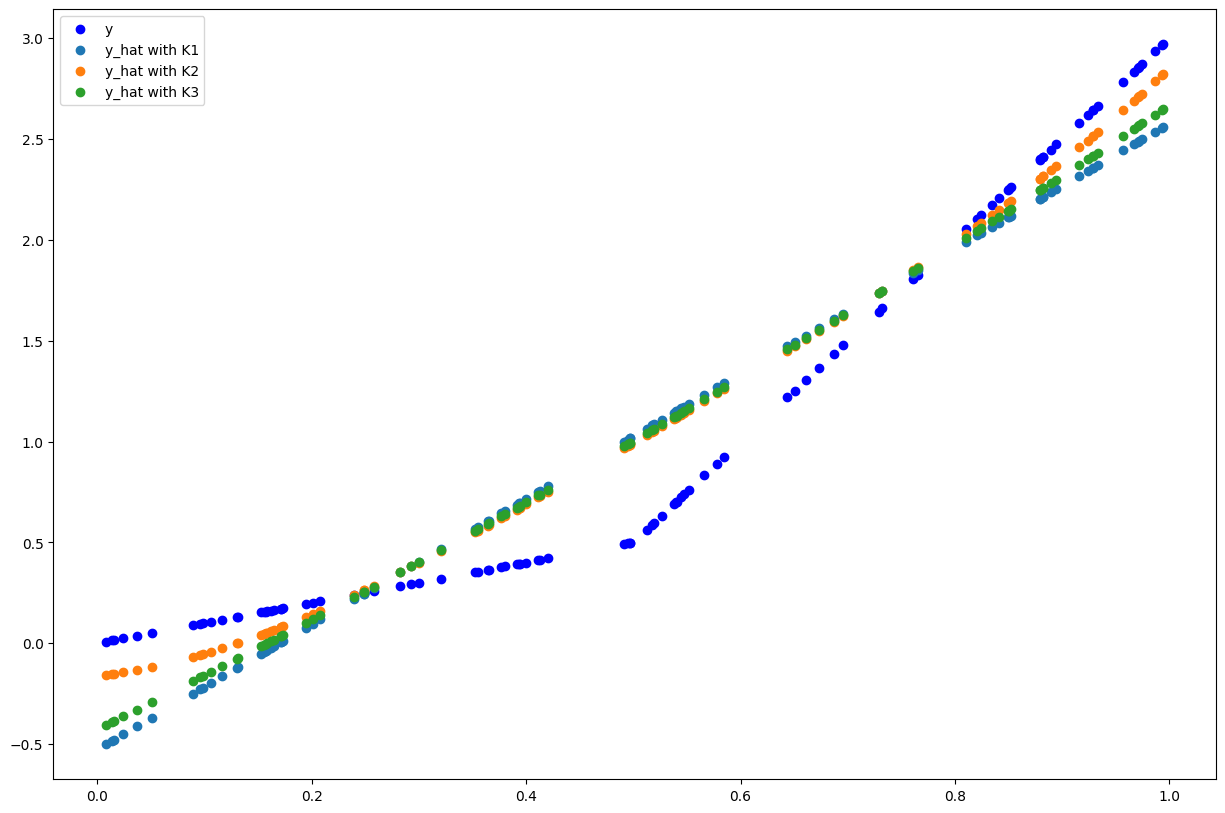

In [133]:
from functools import partial # You may want to use this to make your life easier.
from importlib import reload
plt.scatter(X, y, c='b', label="y")
for i, kernel in enumerate([
        K1,
        partial(K2, lam=1),
        partial(K3, lam=1),
#        partial(K4, L=2), # raises error due to singular matrix
    ]):
    y_hat = pred(X, y, kernel)
    plt.scatter(X, y_hat, label=f"y_hat with K{i+1}")
    
# Adding a legend so we know which kernel produced what is good style.
plt.legend()

Firstly, we could not produce the plot for `K4`, because the provided `utils.loess` implementation does not work when the kernel gives values of `0`. This is due to such values resulting in singular matrices which `loess` tries to use with an equation solver. The implementation from `scikit-misc` package did not work for us either.

With that in mind, we see that `K1` results in a regular linear regression which is equivalent to fitting the same line at each point.

`K2` places approximately the same high weight on nearby data points, but very little weight on the further ones (somewhat similar to a step function). Which results in similar predictions to `K1` in the middle, but closer predictions to $y$ at the edges. This method approaches `K1` as we increase $\lambda$.

`K3` produces exponentially decreasing weights as we move away from the point, which result closer and closer predictions to $y$ as we increase $\lambda$.

As for `K4`, given the nature of the kernel function, we expect it to produce the best results for this data distribution. Since `K4` splits the data points around the line $x = 0.5$, such that regression on any side of the line only takes into account the points on the same side. This is the same as fitting two linear models, one for $x \leq 0.5$ and one for $x > 0.5$, which fits the data very well.